# Rebound Effect of Driving a Green Vehicle

This project aims to ask the question "Does owning an _energy efficient vehicle_ lead to longer driving distance". Using data from [National Household Travel Survey(2017)](https://nhts.ornl.gov/), I explore how is households' driving pattern correlated with owning an _energy efficient vehicle_, which includes hybrid electric vehicles(HEV), plug-in hybrid electric vehicles(PHEV), electric vehicles(EV), and other alternative fuel vehicles. 

The question could be of interest to policy makers who provide financial incentives for purchasing _energy efficient vehicles_. Policy makers promote _energy efficient vehicles_ with a hope to reduce the environmental impact of driving. However, if there exists the notorious _rebound effect_, which means "owning a green vehicle leads to more driving", the environmental benefit of driving a green vehicle would be discounted. Therefore it would be benificial to the policy maker to detect and quantify such _rebound effect_.

A main difficulty of quantifying rebound effect is "selection bias": households who anticipate to drive longer mileage have greater incentive to purchase energy efficient vehicles due to fuel cost saving. Not addressing this issue will result in over-estimate in the rebound effect. To alleviate such concern, I use propensity score matching method to first pair up households with similar characteristics and are equally likely to purchase energy efficient vehicles, then compair the difference of their driving distance. Since the paired households are believed to be equally likely to purchase energy efficient vehicles, the purchase decision becomes quasi-random, eliminating the selection bias.  

The dataset contains information regarding to: 
* households' size, income, state, urban/rural area, number of adults, number of vehicles, etc.
* vehicles' fuel type, size, annual mileage, etc.

The following code will first import and clean the dataset, and then use propensity score matching method to calculate how much extra mileage are caused by owning a green vehicle.



In [1]:

import pandas as pd
import numpy as np
from numpy import *
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from pymatch.Matcher import Matcher
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import and clean dataset

In [2]:
data = pd.read_csv('/Users/chengchen/Dropbox/NHTS_2018/data/NHTS2017/vehpub.csv')
data.head()

,HOUSEID,VEHID,VEHYEAR,VEHAGE,MAKE,MODEL,FUELTYPE,VEHTYPE,WHOMAIN,OD_READ,...,HH_CBSA,HBHTNRNT,HBPPOPDN,HBRESDN,HTEEMPDN,HTHTNRNT,HTPPOPDN,HTRESDN,SMPLSRCE,WTHHFIN
0,30000007,1,2007,10,49,49032,1,1,3,69000,...,XXXXX,20,1500,750,750,50,1500,750,2,187.31432
1,30000007,2,2004,13,49,49442,1,2,-8,164000,...,XXXXX,20,1500,750,750,50,1500,750,2,187.31432
2,30000007,3,1998,19,19,19014,1,1,1,120000,...,XXXXX,20,1500,750,750,50,1500,750,2,187.31432
3,30000007,4,1997,20,19,19021,1,1,2,-88,...,XXXXX,20,1500,750,750,50,1500,750,2,187.31432
4,30000007,5,1993,24,20,20481,1,4,2,300000,...,XXXXX,20,1500,750,750,50,1500,750,2,187.31432


In [3]:
data = data[data.FUELTYPE<4] 
data = data[data.FUELTYPE>0] 
data = data[data.ANNMILES>0] 
data = data[data.HHFAMINC>0] 
data = data[data.HOMEOWN>0] 
data = data[data.VEHAGE>0] 
data = data[data.VEHTYPE>0]# drop the observations where some information is missing
income_dic = {1:5000, 2:12500, 3:20000, 4:30000, 5:42500, 6:62500, 7:87500, 8:112500, 9: 137500, 10: 175000, 11:225000}
data['income'] = data['HHFAMINC'].map(income_dic)
# map the mean income amount of the income category in the survey
home_dic = {1:1, 2:0, 97:0}
# yes: owning home  no: not owning home
data['homeown'] = data['HOMEOWN'].map(home_dic)
urban_dic = {1:'urban_area',2:'urban_cluster',3:'near_urban',4:'not_urban'}
data['urban'] = data['URBAN'].map(urban_dic)
vehtype_dic = {1: 'car',2: 'van',3: 'SUV',4: 'pickup',5: 'truck',6: 'RV',7: 'motorcycle',97: 'else'}
data['vehtype'] = data['VEHTYPE'].map(vehtype_dic)
fueltype_dic = {1: 'gas', 2: 'diesel', 3: 'hybrid/electric/alternative'}
data['fueltype'] = data['FUELTYPE'].map(fueltype_dic)
data.groupby('fueltype')['fueltype'].count()


fueltype
diesel                           5362
gas                            170384
hybrid/electric/alternative      4966
Name: fueltype, dtype: int64

In [4]:
data.groupby('fueltype')['ANNMILES'].mean()

fueltype
diesel                         11247.242260
gas                             9620.500235
hybrid/electric/alternative    12308.237213
Name: ANNMILES, dtype: float64

Above shows the mean annual mileage of vehicles of different fuel types. As can be seen, the lower the fuel cost, the longer the mileage driven is.

In [5]:
htype_dic = {1:  'biodiesel', 2:  'plug-in hybrid', 3:  'electric', 4:  'hybrid', -9: 'NA', -8: 'NA', -1: 'NA', 97: 'NA'}
data['hfuel'] = data['HFUEL'].map(htype_dic)
data.groupby(['fueltype','hfuel'])['ANNMILES'].mean()

fueltype                     hfuel         
diesel                       NA                11247.242260
gas                          NA                 9620.500235
hybrid/electric/alternative  NA                12387.113208
                             biodiesel         12541.944444
                             electric           8235.281720
                             hybrid            12874.606100
                             plug-in hybrid    11516.482587
Name: ANNMILES, dtype: float64

Within the category of energy efficient vehicle, annual mileage ranking is : <br>
hybrid > biudiesel > plug-in hybrid > electric <br>
(Battery size probably plays a role in limiting the mileage of pure electric vehicles.) <br>

In [6]:
area_avg_mile = data.groupby(['HHSTATE','HH_CBSA'])['ANNMILES'].mean().to_frame()
# average annual driving distance of each region (State + Core Based Statistical Area)
data = pd.merge(data,area_avg_mile, how = 'right', left_on = ['HHSTATE','HH_CBSA'], right_index = True)
# add as new column in the dataframe
data = data.rename(columns = {'ANNMILES_x': 'ANNMILES', 'ANNMILES_y': 'area_avg_mile'})
data['relative_mile'] = data['ANNMILES']/data['area_avg_mile']
# this is relative driving milage, compared to the average level of the local area
data.groupby(['fueltype','hfuel'])['relative_mile'].mean()


fueltype                     hfuel         
diesel                       NA                1.173388
gas                          NA                0.985955
hybrid/electric/alternative  NA                1.284829
                             biodiesel         1.306946
                             electric          0.888567
                             hybrid            1.351362
                             plug-in hybrid    1.223351
Name: relative_mile, dtype: float64

Energy efficient vehicles are driven for more mileage compared to its local average levels.
This further comfirms the driving behavior pattern. Until this stage we have looked at the general data pattern without handling the "selection bias" issue. We will try to deal with this problem using propensity score matching.<br><br>
# Propensity Score Matching
The following section will match the treatment/control groups:
* treatment group: hybrid/electric/alternative vehicles
* control group: gasoline/diesel vehicles
They will be matched by both household and vehicle characteristics. The python package [pymatch](https://github.com/benmiroglio/pymatch) will be used here.

In [7]:
trt_dic = {1: False, 2: False,3: True}
data['treatment'] = data['FUELTYPE'].map(trt_dic)
fields = ["income", "homeown", "urban", "vehtype", "VEHAGE", "HHSIZE", "HHSTATE", "HHVEHCNT", "treatment", "ANNMILES"] 
data_match = data[fields]
data_match.head()
treatment = data_match[data_match.treatment == 1]
control = data_match[data_match.treatment == 0]
m = Matcher(treatment, control, yvar = "treatment", exclude = ["ANNMILES"])

Formula:
treatment ~ income+homeown+urban+vehtype+VEHAGE+HHSIZE+HHSTATE+HHVEHCNT
n majority: 175746
n minority: 4966


In [8]:
np.random.seed(1)
m.fit_scores(balance = True, nmodels = 100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 76.45%


This step calculates the **propensity score** (probability of purchasing a clean energy vehicle).<br>
The treatment group (minority) has 4966 obs, whereas control group (majority) has 175746 obs, rendering imbalanced sample. <br>
Use "balance = true" so that when fitting logistic models, equal number of treatment and control samples are used.<br>
Use "nmodels = 100" to randomly draw sample for 100 times, so that the logistic model will be fitted using more data points from the control group (the majority group).<br>
    
The **average accuracy** is 76.45%, suggesting a good fit of the model.

In [9]:
m.predict_scores() # calculate p-score

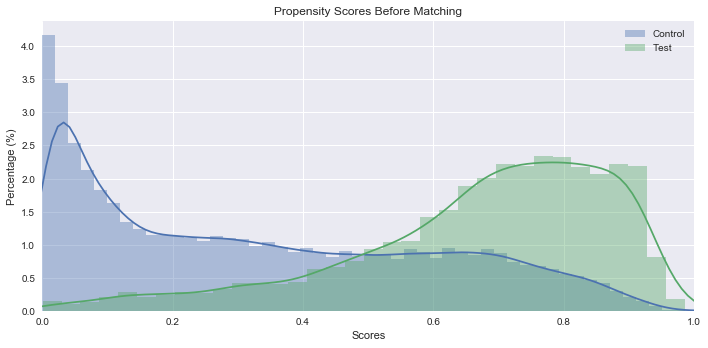

In [10]:
m.plot_scores()

The above step plot the p-score distribution of treatment group and control group. <br>
For each p-score, there is positive chance of belonging to either group. (**common support**) <br>
The treatment group has much higher scores than the control group. (**separability**) <br>
Such evidence support the use of propensity score matching.

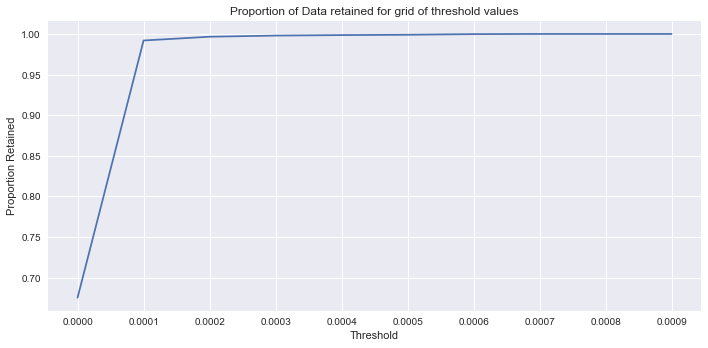

In [11]:
m.tune_threshold(method='random')

Tune threshold for matching:<br>
From the graph: a threshold at 0.0003 will retain 100% of the data.

In [13]:
m.match(method = "min", nmatches = 1, threshold = 0.0003)
# matching the treatment data points with control data points
m.matched_data.sort_values("match_id").head(6)

,income,homeown,urban,vehtype,VEHAGE,HHSIZE,HHSTATE,HHVEHCNT,treatment,ANNMILES,scores,match_id,record_id
0,62500,1,not_urban,car,7,2,NC,2,1,15000,0.578314,0,0
12165,62500,1,not_urban,car,7,2,NC,2,0,10000,0.578314,0,12165
1,112500,1,not_urban,car,12,3,NC,7,1,8571,0.368433,1,1
148095,20000,1,urban_cluster,car,11,2,AZ,5,0,12000,0.368417,1,148095
2,112500,1,urban_area,car,3,2,NC,2,1,8000,0.759758,2,2
143971,112500,1,urban_area,car,3,2,NC,2,0,10500,0.759758,2,143971


In [14]:
m.record_frequency()

,freq,n_records
0,1,8278
1,2,414
2,3,100
3,4,35
4,5,19
5,6,16
6,7,6
7,8,1
8,9,3
9,10,2


8278 of the matched majority group recors occur only once, 414 twice, etc.<br><br>
Next we will assess the quality of the matching.

In [17]:
categorical_results = m.compare_categorical(return_table = True)
categorical_results

,var,before,after
0,urban,0.0,0.119381
1,vehtype,0.0,0.752881
2,HHSTATE,0.0,0.960683


Above results(pvalue) shows chi-square test for independence before and after matching. After matching we want this pvalue to be > 0.05, resulting in failure to reject the null hypothesis that the frequency of the enumerated term values are independent of the test and control grousps.

In [18]:
cc = m.compare_continuous(return_table = True)

In [19]:
cc

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,income,0.0,0.632,0.0,0.441,0.416377,0.00000,0.494024,0.005524
1,homeown,0.0,0.224,1.0,1.000,0.000000,0.00000,0.076510,-0.023737
2,VEHAGE,0.0,0.488,0.0,0.567,-0.501484,0.24207,-0.581891,-0.009603
3,HHSIZE,0.0,0.116,1.0,1.000,0.000000,0.00000,0.018855,0.048497
4,HHVEHCNT,0.0,0.874,1.0,1.000,0.000000,0.00000,-0.176163,0.011618


Tests included: Kolmogorov-Smirnov Goodness of fit Test (KS-test) and Chi-Square Distance. We want pvalues from both the KS-test and the grouped permutation of the Chi-Square distance after matching to be > 0.05, and they both are.<br><br>

# Results
Next we will assess the difference in driving distance of the treatment and control group.

Calculate the difference through linear regression:

In [22]:
covariates = ["treatment", "income", "homeown", "VEHAGE", "HHSIZE" ,"HHVEHCNT"] 
linmodel = sm.OLS(m.matched_data["ANNMILES"], 
                  pd.concat([m.matched_data[covariates], 
                             pd.get_dummies(m.matched_data["HHSTATE"]),
                             pd.get_dummies(m.matched_data["urban"]),
                             pd.get_dummies(m.matched_data["vehtype"])],axis=1)).fit()
print('results from propensity score matching')
print('ATE:',linmodel.params.treatment)
print('standard error:',linmodel.tvalues.treatment)

results from propensity score matching
ATE: 1203.44791754
standard error: 4.94245467924


The above shows that energy efficient vehicles can induce 1203 miles more of annual driving distance, and the result is statistically significant.

In [27]:
unmatched1 = data[data['treatment']==1]['ANNMILES'].mean()
unmatched0 = data[data['treatment']==0]['ANNMILES'].mean()
unmatched1 - unmatched0

2638.105175904215

The above is the raw difference of driving distance between two groups (without matching). This is greater than the matched result, providing evidence for selection bias: those who buy energy efficient vehicles probably drive more on average. Yet, the result from PSM indicates despite of such selection bias, buying an energy efficient vehicle will change people's driving behavior and induce more driving. <br><br>

# More analysis
Another question that policy makers might be interested in is "Does this extra mileage of energy efficient vehicle substitute some mileage from other vehicles owned by the household?".If total annual mileage of households who own energy efficient vehicles does not differ from similar households who do not own energy efficient vehicles, that might suggest subsitution between household vehicles. Therefore the following section will aggregate data to household level and conduct similar matching procedure to households.
 

In [28]:
hh_total_mile = data.groupby(['HOUSEID'])['ANNMILES'].sum() \
    .to_frame().rename(columns = {'ANNMILES': 'hh_total_mile'})
hh_own_clean_veh = ((data.groupby(['HOUSEID'])['treatment'].sum()>0) \
    .to_frame()*1).rename(columns = {'treatment': 'hh_own_clean_veh'})
n_clean_veh = data.groupby(['HOUSEID'])['treatment'].sum() \
    .to_frame().rename(columns = {'treatment': 'n_clean_veh'})
data_hh = pd.merge(data, hh_total_mile, how = 'inner', left_on = ['HOUSEID'], right_index = True)
data_hh = pd.merge(data_hh, hh_own_clean_veh, how = 'inner', left_on = ['HOUSEID'], right_index = True)
data_hh = pd.merge(data_hh, n_clean_veh, how = 'inner', left_on = ['HOUSEID'], right_index = True)
data_hh = data_hh.drop_duplicates(['HOUSEID'], keep='first')
data_hh = data_hh[data_hh['NUMADLT']>0]
data_hh['mile_per_adult'] = data_hh['hh_total_mile']/data_hh['NUMADLT']
data_hh['num_children'] = data_hh['HHSIZE'] - data_hh['NUMADLT']

In [29]:
fields = ["income", "homeown", "urban", "HHSIZE", "HHSTATE", "HHVEHCNT", "hh_own_clean_veh", "hh_total_mile","n_clean_veh", "mile_per_adult", "num_children"] 
data_match = data_hh[fields]
data_match.head()
treatment = data_match[data_match.hh_own_clean_veh == 1]
control = data_match[data_match.hh_own_clean_veh == 0]
m = Matcher(treatment, control, yvar = "hh_own_clean_veh", exclude = ["hh_total_mile","n_clean_veh","mile_per_adult"])


Formula:
hh_own_clean_veh ~ income+homeown+urban+HHSIZE+HHSTATE+HHVEHCNT+num_children
n majority: 90974
n minority: 4568


In [31]:
np.random.seed(1)
m.fit_scores(balance = True, nmodels = 100)
# average accuracy: 64.91%


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 64.91%


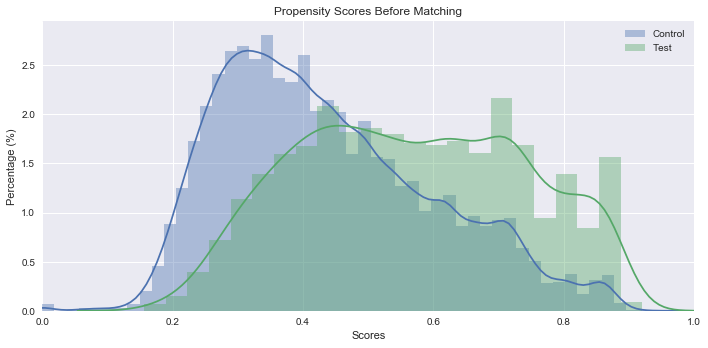

In [32]:
m.predict_scores() # calculate p-score
m.plot_scores()

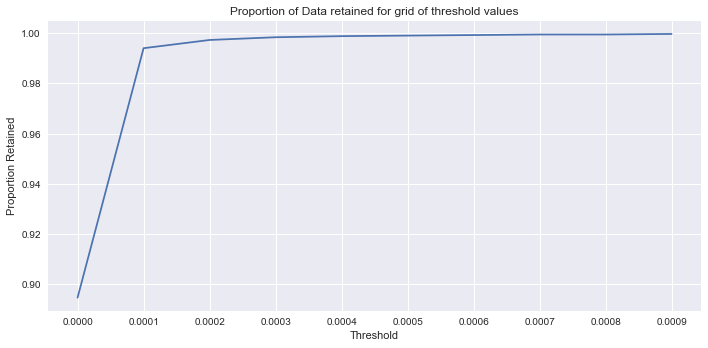

In [33]:
m.tune_threshold(method='random')

In [34]:
m.match(method = "min", nmatches = 1, threshold = 0.0008)

In [35]:
m.matched_data.sort_values("match_id").head(6)

,income,homeown,urban,HHSIZE,HHSTATE,HHVEHCNT,hh_own_clean_veh,hh_total_mile,n_clean_veh,mile_per_adult,num_children,scores,match_id,record_id
0,62500,1,not_urban,2,NC,2,1,20000,1.0,10000.000000,0,0.372852,0,0
8288,62500,1,not_urban,2,NC,2,0,10000,0.0,5000.000000,0,0.372852,0,8288
1,112500,1,not_urban,3,NC,7,1,65374,1.0,21791.333333,0,0.554536,1,1
8861,112500,1,not_urban,3,NC,7,0,45850,0.0,15283.333333,0,0.554536,1,8861
2,112500,1,urban_area,2,NC,2,1,20000,2.0,10000.000000,0,0.540142,2,2
6376,112500,1,urban_area,2,NC,2,0,12800,0.0,6400.000000,0,0.540142,2,6376


In [36]:
m.record_frequency()

,freq,n_records
0,1,6169
1,2,323
2,3,105
3,4,54
4,5,39
5,6,15
6,7,22
7,8,20
8,9,15
9,10,12


In [37]:
categorical_results = m.compare_categorical(return_table = True)
categorical_results

,var,before,after
0,urban,0.0,0.845934
1,HHSTATE,0.0,0.999939


In [38]:
cc = m.compare_continuous(return_table = True)
cc

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,income,0.0,0.998,0.0,0.998,0.856976,0.0,0.645195,0.005165
1,homeown,0.0,0.899,1.0,1.000,0.000000,0.0,0.180183,-0.003286
2,HHSIZE,0.0,0.512,1.0,1.000,0.000000,0.0,0.182328,0.024008
3,HHVEHCNT,0.0,0.842,1.0,1.000,0.000000,0.0,0.210103,0.019599
4,num_children,0.0,0.287,1.0,1.000,0.000000,0.0,0.059526,0.014982


In [42]:
covariates = ["hh_own_clean_veh", "income", "homeown", "HHSIZE" ,"HHVEHCNT"] 
linmodel = sm.OLS(m.matched_data["hh_total_mile"], 
                  pd.concat([m.matched_data[covariates], 
                             pd.get_dummies(m.matched_data["HHSTATE"]),
                             pd.get_dummies(m.matched_data["urban"])],axis=1)).fit()
print('the effect of owning a clean vehicle on household miles driven')
print('ATE:',linmodel.params.hh_own_clean_veh)
print('standard error:',linmodel.tvalues.hh_own_clean_veh)

the effect of owning a clean vehicle on household miles driven
ATE: 1729.01924946
standard error: 4.45509371037


In [43]:
# use "number of clean vehicle" as independent var instead
covariates2 = ["n_clean_veh", "income", "homeown", "HHSIZE" ,"HHVEHCNT"] 
linmodel2 = sm.OLS(m.matched_data["hh_total_mile"], 
                  pd.concat([m.matched_data[covariates2], 
                             pd.get_dummies(m.matched_data["HHSTATE"]),
                             pd.get_dummies(m.matched_data["urban"])],axis=1)).fit()
print('the effect of owning one more clean vehicle on household miles driven')
print('ATE:',linmodel2.params.n_clean_veh)
print('standard error:',linmodel2.tvalues.n_clean_veh)

the effect of owning one more clean vehicle on household miles driven
ATE: 1779.57031899
standard error: 5.34001409422


In [44]:

# use "mile per adult" as dependent var, "own clean veh dummy" as independent var
covariates3 = ["hh_own_clean_veh", "income", "homeown", "num_children" ,"HHVEHCNT"] 
linmodel3 = sm.OLS(m.matched_data["mile_per_adult"], 
                  pd.concat([m.matched_data[covariates3], 
                             pd.get_dummies(m.matched_data["HHSTATE"]),
                             pd.get_dummies(m.matched_data["urban"])],axis=1)).fit()
print('the effect of owning a clean vehicle on miles driven per adult in the household')
print('ATE:',linmodel3.params.hh_own_clean_veh)
print('standard error:',linmodel3.tvalues.hh_own_clean_veh)

the effect of owning a clean vehicle on miles driven per adult in the household
ATE: 881.540124761
standard error: 3.80814019464


Findout from this section: 
* Households that purchase clean vehicles are driving more annual miles,which does not support the substitution effect evidence. 
* Individuals in households with clean energy vehicles are driving more miles, which is consistent with the above results. <br><br>

Combining the results, we can assert that owning an energy efficient vehicle leads to more driving, and this does not substitute the mileage of other vehicles owned by the household. The **rebound effect does exist for energy efficient vehicles**. 